# Table of Contents: <a class="anchor" id="contents"></a>

## [Required User Input: Path for Plots and Charts](#requiredinput)

* [Importing and Cleaning Data](#import)
* [Function Definitions](#funcdef)
    * [Target and Feature Set for Validation](#targetfeature)
    * [Cross Validated ROC Chart](#cvroc)
* [Target: HNHC](#hnhc)
    * [Logistic Regression Validation - HNHC](#lrhnhc)
    * [Logistic Regression Validation - HNHC without 'los'](#lrhnhcwolos)
    * [Decision Tree Classifier Validation - HNHC](#dtchnhc)
    * [Decision Tree Classifier Validation - HNHC without 'los'](#dtchnhcwolos)
    * [XGBoost Classifier Validation - HNHC](#xgbchnhc)
    * [XGBoost Classifier Validation - HNHC without 'los'](#xgbchnhcwolos)
* [Target: READM_NINETY_DAYS](#ninety)
    * [Logistic Regression Validation - READM_NINETY_DAYS](#lrninety)
    * [Decision Tree Classifier Validation - READM_NINETY_DAYS](#dtcninety)
    * [XGBoost Classifier Validation - READM_NINETY_DAYS](#xgbcninety)

## Importing and cleaning data <a class="anchor" id="import"></a>

[Return to Table of Contents](#contents)

In [1]:
# Import dependencies
from sklearn import tree, metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
# from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, plot_roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from numpy import interp
import os
from os import path
import getpass
import warnings
import dask.dataframe as dd
from IPython.display import display 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

# Required User Input: Path for Plots and Charts <a class="anchor" id="requiredinput"></a>

[Return to Table of Contents](#contents)

In [2]:
# Get the current user's computer name.
pc_name = getpass.getuser()

#############################
'''SET PATH TO SAVE IMAGES'''
#############################
# Set 'PATH' as the path to where any plots/charts should be saved.
# Default path set to desktop:
# PATH = f'C:/Users/{pc_name}/Desktop'
PATH = f'C:/Users/{pc_name}/Desktop/VA_ML_Research/UCSD_NRD_2017'

# Path to where plots/charts will be saved.
images_folder = f'{PATH}/images'

# If the folder already exists, pass through. If the folder does not exist, create the folder.
if path.exists(images_folder):
    # Pass through.
    pass
else:
    # Create a folder to save plots/charts in.
    os.makedirs(images_folder)

In [3]:
# Read in the data as a dataframe.
df = pd.read_csv('data/NRD_2017_Defined_Cohort_Five_I10_DX.csv')
df.head()

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,cm_wghtloss,cm_anemdef,cm_renlfail,cm_lymph,cm_para,cm_ulcer,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,new_osteo_adm,pqi_dm_short,fractures,new_mi_adm,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusi

In [4]:
# Make a copy of the dataframe
df_copy = df.copy()
df_copy.head()

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,cm_wghtloss,cm_anemdef,cm_renlfail,cm_lymph,cm_para,cm_ulcer,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,new_osteo_adm,pqi_dm_short,fractures,new_mi_adm,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusi

In [5]:
# Check the back end of the data
df_copy.tail()

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,cm_wghtloss,cm_anemdef,cm_renlfail,cm_lymph,cm_para,cm_ulcer,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,new_osteo_adm,pqi_dm_short,fractures,new_mi_adm,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusi

In [6]:
# Recoding the ibd_readm outcome variable
readm_set = set()
for index, row in df_copy[['nrd_visitlink','readm_during_fu']].iterrows():
    if row[1] == 1:
        readm_set.add(row[0])
        
readm_list = list(readm_set)

# Initalize the new column with a value of 0
df_copy['ibd_readm'] = 0
df_copy.loc[df_copy.nrd_visitlink.isin(readm_list), 'ibd_readm'] = 1
df_copy[['nrd_visitlink','ibd_index_hospitalization', 'ibd_readm']].head(15)

,nrd_visitlink,ibd_index_hospitalization,ibd_readm
0,e0007w8,1,0
1,e0009vi,1,0
2,e0021xf,1,0
3,e002hi0,1,1
4,e002hi0,0,1
5,e002k2h,1,0
6,e002vve,1,0
7,e003021,1,0
8,e004bp7,1,1
9,e004bp7,0,1


In [7]:
df_copy[['nrd_visitlink', 'pay1', 'ibd_index_hospitalization', 'ibd_readm']].head(15)

,nrd_visitlink,pay1,ibd_index_hospitalization,ibd_readm
0,e0007w8,1.0,1,0
1,e0009vi,2.0,1,0
2,e0021xf,1.0,1,0
3,e002hi0,3.0,1,1
4,e002hi0,3.0,0,1
5,e002k2h,1.0,1,0
6,e002vve,3.0,1,0
7,e003021,1.0,1,0
8,e004bp7,3.0,1,1
9,e004bp7,3.0,0,1


In [8]:
# Number of index hospitalizations
index_hosp_counts = df_copy['ibd_index_hospitalization'].value_counts()
index_hosp_counts

0    42225
1    40177
Name: ibd_index_hospitalization, dtype: int64

In [9]:
# Number of readmissions within six months
readm_counts = df_copy['ibd_readm'].value_counts()
readm_counts

1    60782
0    21620
Name: ibd_readm, dtype: int64

In [10]:
# Filter the data so that only patients with an index hospitalizations are in a DataFrame
readm_data_df = df_copy.loc[df_copy["ibd_index_hospitalization"] == 1, :]

# Check to ensure the filter worked correctly
readm_data_df["ibd_index_hospitalization"].count()

40177

In [11]:
# Check for null values
df_copy.isnull().sum()

      74112
i10_pr6                                                                           76799
i10_pr7                                                                           79235
i10_pr8                                                                           80229
i10_pr9                                                                           80868
i10_pr10                                                                          81282
i10_pr11                                                                          81574
i10_pr12                                                                          81796
i10_pr13                                                                          81925
i10_pr14                                                                          82017
i10_pr15                                                                          82145
i10_pr16                                                                          82190
i10_pr17            

In [12]:
# # WE ARE NOT USING RFE ON THIS VALIDATION DATA SET SO THIS NEXT PART IS NOT NECESSARY, IF USING RFE, FEATURES WILL NEED TO BE CROSS WALKED FROM 2013 TO 2017.
# # ANYTHING COMMENTED OUT FROM HERE ON OUT IS NOT NECESSARY FOR VALIDATION.

# # Initially run with entire feature list so RFE can use backwards selection to pick top features
# data = readm_data_df[['hnhc_patients', 'has_90_day_readm', 'steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age', 'female', 'los', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location', 'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids', 'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf', 'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug', 'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets', 'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych', 'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve', 'cm_wghtloss', 'diabetes', 'copd', 'cm_smoking', 'blood_transfusion', 'ibd_procedures', 'cc_index', 'new_cc_index', 'fractures', 'thromboses', 'unplanned_adm', 'pq1_dm_short', 'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn', 'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti', 'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate', 'new_mi_adm', 'new_chf_adm', 'new_unstableangina_adm', 'new_arrhythmia_adm', 'new_cardiacarrest_adm', 'new_meningitis_adm', 'new_encephalitis_adm', 'new_endocarditis_adm', 'new_pneumonia_adm', 'new_pyelonephritis_adm', 'new_osteo_adm', 'new_septicemia_adm', 'new_cdiff_adm', 'new_tb_adm', 'new_atypicalmyco_adm', 'new_fungal_adm', 'new_listeriosis_adm', 'new_leishmaniasis_adm', 'new_pcp_adm', 'chronic_pain', 'ibd_surgery_adm', 'frailty_risk_score', 'frailty_risk_category_index', 'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'prevent_readm', 'cardiac_adm', 'cvd_adm', 'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm', 'malignancies_adm', 'fracture_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm']]

# cleaned_data = data.dropna(axis='rows')
# cleaned_data

# Drop all columns that contain string values and fill NaN's with 0
readm_data_df[readm_data_df.columns] = readm_data_df[readm_data_df.columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()

In [13]:
# # Removing correlated features
# correlated_features = set()
# correlation_matrix = readm_data_df.drop('hnhc_patients', axis=1).corr()

# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > 0.75:
#             colname = correlation_matrix.columns[i]
#             correlated_features.add(colname)

In [14]:
# # Drop these features
# correlated_features

In [15]:
# Get a dataframe of the cleaned data
cleaned_data = readm_data_df.dropna(axis='rows')
cleaned_data

,key_nrd,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,i10_dx1,i10_dx2,i10_dx3,i10_dx4,i10_dx5,i10_dx6,i10_dx7,i10_dx8,i10_dx9,i10_dx10,i10_dx11,i10_dx12,i10_dx13,i10_dx14,i10_dx15,i10_dx16,i10_dx17,i10_dx18,i10_dx19,i10_dx20,i10_dx21,i10_dx22,i10_dx23,i10_dx24,i10_dx25,i10_dx26,i10_dx27,i10_dx28,i10_dx29,i10_dx30,i10_dx31,i10_dx32,i10_dx33,i10_dx34,i10_dx35,i10_dx36,i10_dx37,i10_dx38,i10_dx39,i10_dx40,elective,female,hcup_ed,hosp_nrd,los,mdc,mdc_nopoa,i10_ndx,i10_npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,pay1,pl_nchs,i10_pr1,i10_pr2,i10_pr3,i10_pr4,i10_pr5,i10_pr6,i10_pr7,i10_pr8,i10_pr9,i10_pr10,i10_pr11,i10_pr12,i10_pr13,i10_pr14,i10_pr15,i10_pr16,i10_pr17,i10_pr18,i10_pr19,i10_pr20,i10_pr21,i10_pr22,i10_pr23,i10_pr24,i10_pr25,prday1,prday2,prday3,prday4,prday5,prday6,prday7,prday8,prday9,prday10,prday11,prday12,prday13,prday14,prday15,prday16,prday17,prday18,prday19,prday20,prday21,prday22,prday23,prday24,prday25,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,dxver,prver,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,aprdrg,aprdrg_risk_mortality,aprdrg_severity,next_nrdday,days_to_readmission,readmission_diagnosis,readmission_los,preventable_admission,pqi_1,pqi_3,pqi_5,pqi_7,pqi_8,pqi_11,pqi_12,pqi_14,pqi_15,pqi_16,pqi_5_15_exclusion,pqi_7_medical_exclusions,pqi_7_procedural_exclusion,pqi_7_8_procedural_exclusion,pqi_11_exclusion,pqi_12_exclusion,pqi_immunocompromise_medical_exclusion,pqi_immunocompromise_procedural_exclusion,pqi_16_exclusion_procedure,pqi_16_amputation_procedure,medical_admission,hfrs_score,hfrs_severity,cc_score,cc_severity,cc_MI,cc_CHF,cc_PVD,cc_CVD,cc_dementia,cc_COPD,cc_rheum,cc_peptic_ulcer,cc_mild_liver_disease,cc_diabetes_wo_complications,cc_diabetes_w_complications,cc_plegia,cc_renal,cc_malignancy,cc_severe_liver,cc_metastasis,cc_AIDS,ibd_diagnosis,ibd_index_hospitalization,intestinal_abscess,meningitis,encephalitis,endocarditis,pneumonia,pyelonephritis,septic_arthritis_osteomyelitis,septicemia_or_bacteremia,clostridium_difficile,pulmonary_tuberculosis,atypical_mycobacteria,cryptococcosis_aspergillosis_histoplasmosis,listeriosis,leishmaniasis,pneumocystis_jiroveci_pneumonia,acute_myocardial_infarction,heart_failure,unstable_angina,arrhythmia,cardiac_arrest,vte_diagnosis_pe_or_dvt,history_of_vte,systemic_steroid_use,chronic_pain,opioid_overuse,depression,anxiety_disorder,bipolar_disorder,schizophrenia,problems_related_to_education_and_literacy,problems_related_to_employment_and_unemployment,occupational_exposure_to_risk_factors,problems_related_to_housing_and_economic_circumstances,problems_related_to_social_environment,problems_related_to_upbringing,other_problems_related_to_primary_support_group_including_family_circumstances,problems_related_to_certain_psychosocial_circumstances,problems_related_to_other_psychosocial_circumstances,thromboses,cm_dmcx,cm_drug,cm_wghtloss,cm_anemdef,cm_renlfail,cm_lymph,cm_para,cm_ulcer,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,new_osteo_adm,pqi_dm_short,fractures,new_mi_adm,intestinal_surgery,flexible_sigmoidoscopy_colonoscopy,blood_transfusion,parenteral_or_enteral_nutrition,serious_infections_during_followup,total_serious_infection_admissions,opportunistic_infections_during_followup,total_opportunistic_infection_admissions,cardiac_during_followup,total_cardiac_admissions,venous_thromboembolism_during_followup,total_venous_thromboembolism_admissions,steroid_use_during_followup,total_steroid_use_admissions,chronic_pain_during_followup,total_chronic_pain_admissions,opioid_overuse_during_followup,total_opioid_overuse_admissions,psychiatric_burden_during_followup,total_psychiatric_burden_admissions,social_determinants_of_health_during_followup,total_social_determinants_of_health_admissions,intestinal_surgery_during_followup,total_intestinal_surgery_admissions,flexible_sigmoidoscopy_colonoscopy_during_followup,total_flexible_sigmoidoscopy_colonoscopy_admissions,blood_transfusi

In [16]:
# # Grab outcome/label names after dropping na's/rows with na's
# target_hnhc = cleaned_data["hnhc_patients"]
# target_hnhc = target_hnhc.astype('int64')
# target_hnhc

In [17]:
# # Grab feature names after dropping na's/rows with na, also drop the correlated features
# cleaned_data_wo_outcome_hnhc = cleaned_data.drop(['hnhc_patients', 'has_90_day_readm'], axis=1)
# featured_names_hnhc = cleaned_data_wo_outcome_hnhc.columns
# featured_names_hnhc

In [18]:
# # Grab feature names after dropping na's/rows with na, also drop the correlated features and drop 'los' for testing
# cleaned_data_wo_outcome_hnhc_no_los = cleaned_data.drop(['hnhc_patients', 'has_90_day_readm', 'los'], axis=1)
# featured_names_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los.columns
# featured_names_hnhc_no_los

In [19]:
# # Repeat the last two steps (above previous code block) for 'readm_ninety_days' as target instead of 'ibd_readm'.
# target_ninety = cleaned_data["has_90_day_readm"]
# target_ninety = target_ninety.astype('int64')
# target_ninety

In [20]:
# cleaned_data_wo_outcome_ninety = cleaned_data.drop(['hnhc_patients', 'has_90_day_readm'], axis=1)
# featured_names_ninety = cleaned_data_wo_outcome_ninety.columns
# featured_names_ninety

In [21]:
# # Make sure the cleaned data also has the correlated features removed and any other variables, such as los, removed when necessary.
# cleaned_data_hnhc = cleaned_data.drop(['has_90_day_readm'], axis=1)

# cleaned_data_hnhc_no_los = cleaned_data.drop(['has_90_day_readm', 'los'], axis=1)

# cleaned_data_ninety = cleaned_data.drop(['hnhc_patients'], axis=1)

In [22]:
# # Check for na values
# cleaned_data_wo_outcome_hnhc.isnull().sum()

# Function Definitions <a class="anchor" id="funcdef"></a>

[Return to Table of Contents](#contents)

## Target and Feature Set for Validation <a class="anchor" id="targetfeature"></a>

[Return to Table of Contents](#contents)

In [23]:
# This function returns a Pandas dataframe containing the specified number of features and a Pandas series containing the target feature.
# list_of_features: List of features from 2013 RFE for the given model. IMPORTANT: The FIRST value in the list must be the TARGET feature.
# readmission_dataframe: The dataframe that has been narrowed down to readmitted patients.
    
def validate_2013(list_of_features, readmission_dataframe):
    # Grab the features from the list and make a new dataframe.
    data = readmission_dataframe[list_of_features]

    # Drop NaN's.
    cleaned_data = data.dropna(axis='rows')

    # Display data.
    print(cleaned_data)

    # Extract the target feature into a Panda Series. The target feature is the first feature in the list.
    target = cleaned_data[list_of_features[0]]
    target = target.astype('int64')

    # Create a Pandas Dataframe without the target feature.
    cleaned_data_wo_outcome = cleaned_data.drop(list_of_features[0], axis=1)

    # Return the target and cleaned data without the target feature.
    return cleaned_data_wo_outcome, target

## Cross Validated ROC Chart <a class="anchor" id="cvroc"></a>

[Return to Table of Contents](#contents)

In [24]:
# This function produces a cross validated ROC chart, with each fold and the mean along with standard deviations.
# Sources: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html, https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
# cv: StratifiedKFold (can be changed if needed)
# classifier: Any model that works with cross validation. Examples: Logistic, Random Forest, Decision Tree, XGBoost, etc.
# X: Features in the form of a Pandas dataframe.
# y: Target in the form of a Pandas Series.
# title: A string for the chart title, not required.
# num_features: An integer value for the number of features being used.
    
def draw_cv_auc_roc(classifier, cv, X, y, num_features, title = 'Receiver Operating Characteristic'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(9.6,7.2))

    i = 0

    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    save_title = title.replace(" ", "_")
    plt.savefig(f'{images_folder}/{num_features}_features_validation/{save_title}_{num_features}_validation', dpi=300)
    plt.show()

# Utilizing RFE to do feature selection

## Target: HNHC <a class="anchor" id="hnhc"></a>

[Return to Table of Contents](#contents)

## Logistic Regression Validation - HNHC <a class="anchor" id="lrhnhc"></a> 

[Return to Table of Contents](#contents)

In [25]:
# Plug in the features found by the LR RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from LR RFE NRD 2013: ['cm_lymph', 'cm_para', 'cm_renlfail', 'cm_ulcer', 'new_osteo_adm']
data_lr_hnhc = ['hnhc_patients', 'cm_lymph', 'cm_para', 'cm_renlfail', 'cm_ulcer', 'new_osteo_adm']

# Readmission dataframe we defined above.
readm_df = cleaned_data

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc = validate_2013(data_lr_hnhc, readm_df)

# Variable for saving the charts.
num_features = 5

       hnhc_patients  cm_lymph  cm_para  cm_renlfail  cm_ulcer  new_osteo_adm
0                0.0       0.0      0.0          0.0       0.0            0.0
1                0.0       0.0      0.0          0.0       0.0            0.0
2                0.0       0.0      0.0          0.0       0.0            0.0
3                0.0       0.0      0.0          0.0       0.0            0.0
5                0.0       0.0      0.0          1.0       0.0            0.0
...              ...       ...      ...          ...       ...            ...
82384            0.0       0.0      0.0          0.0       0.0            0.0
82388            0.0       0.0      0.0          0.0       0.0            0.0
82393            0.0       0.0      0.0          0.0       0.0            0.0
82394            0.0       0.0      0.0          0.0       0.0            0.0
82400            0.0       0.0      0.0          0.0       0.0            0.0

[40177 rows x 6 columns]


In [26]:
# Initial model with Logistic Regression.
model_lr_hnhc = LogisticRegression(random_state = 42)
X_train_lr_hnhc, X_test_lr_hnhc, y_train_lr_hnhc, y_test_lr_hnhc = train_test_split(cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc, random_state=42)
model_lr_hnhc.fit(X_train_lr_hnhc, y_train_lr_hnhc)
print(f'Training Score: {model_lr_hnhc.score(X_train_lr_hnhc, y_train_lr_hnhc)}')
print(f'Testing Score: {model_lr_hnhc.score(X_test_lr_hnhc, y_test_lr_hnhc)}')

Training Score: 0.9654520111509359
Testing Score: 0.9640617222498755


In [27]:
# K-Fold Validation using Logistic Regression.
scores_lr_hnhc = cross_validate(model_lr_hnhc, cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_lr_hnhc = pd.DataFrame(scores_lr_hnhc)
scores_df_lr_hnhc

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.077140,0.007963,0.584032,0.560378,1.0,0.500000,0.007143,0.000792,0.965406,0.965099
1,0.055913,0.007744,0.568319,0.562122,0.0,1.000000,0.000000,0.001585,0.964908,0.965154
2,0.055979,0.006980,0.543162,0.564914,0.0,0.666667,0.000000,0.001585,0.965157,0.965126
3,0.073383,0.005998,0.569918,0.561944,0.0,0.666667,0.000000,0.001585,0.965157,0.965126
4,0.063746,0.007458,0.544581,0.564755,0.0,0.666667,0.000000,0.001585,0.965157,0.965126
5,0.057966,0.006980,0.551755,0.563965,0.0,0.666667,0.000000,0.001586,0.964908,0.965154
6,0.056445,0.007995,0.569840,0.561947,0.0,0.666667,0.000000,0.001586,0.964908,0.965154
7,0.058933,0.007014,0.574499,0.561161,0.0,0.666667,0.000000,0.001585,0.965148,0.965127
8,0.071621,0.007996,0.564901,0.562500,0.0,0.666667,0.000000,0.001585,0.965148,0.965127
9,0.067025,0.007950,0.550414,0.564104,1.0,0.500000,0.007143,0.000792,0.965397,0.965100


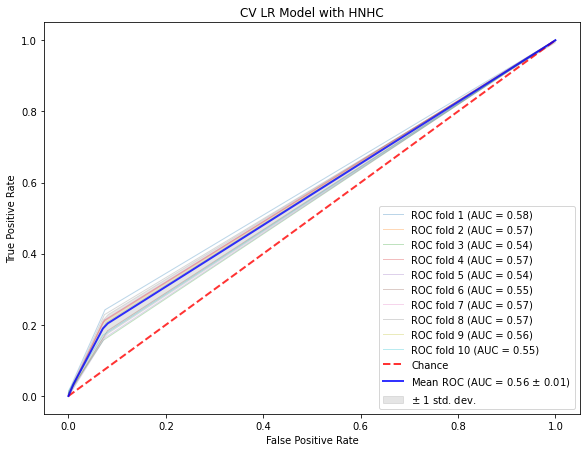

In [28]:
# Subfolder where plots/charts will be saved.
PATH_SUB = f'{images_folder}/{num_features}_features_validation'

# If the folder already exists, pass through. If the folder does not exist, create the folder.
if path.exists(PATH_SUB):
    # Pass through.
    pass
else:
    # Create a folder to save plots/charts in. 
    os.makedirs(f'{images_folder}/{num_features}_features_validation')

# Cross validated ROC/AUC chart, run classifier with cross-validation and plot ROC curves.
cv = StratifiedKFold(n_splits=10)
draw_cv_auc_roc(model_lr_hnhc, cv, cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc, num_features, 'CV LR Model with HNHC')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


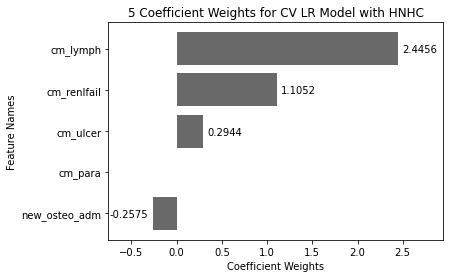

In [32]:
# Grab the coefficient weights using the Logistic Regression model.
for value in model_lr_hnhc.coef_:
    importance_lr_hnhc = sorted(zip(value, X_train_lr_hnhc))

# Graph coefficient weights for Logistic Regression.
value_labels_lr_hnhc = [x[0] for x in importance_lr_hnhc]
feature_names_lr_hnhc = [y[1] for y in importance_lr_hnhc]
plt.barh(feature_names_lr_hnhc, value_labels_lr_hnhc, color='dimgray')
for index, value in enumerate(value_labels_lr_hnhc):
    if value_labels_lr_hnhc[index] >= 0:
        plt.text(value/value_labels_lr_hnhc[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels_lr_hnhc[index] < 0:
        plt.text(-value/value_labels_lr_hnhc[index]+value+0.52, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels_lr_hnhc)-0.5, max(value_labels_lr_hnhc)+0.5))
plt.ylabel('Feature Names')
plt.title(f'{num_features} Coefficient Weights for CV LR Model with HNHC')
plt.savefig(f'{images_folder}\{num_features}_features\CV_LR_HNHC_Coefficient_Weights_{num_features}_validation', dpi=300)
plt.show()

## Logistic Regression Validation - HNHC without 'los' <a class="anchor" id="lrhnhcwolos"></a> 

[Return to Table of Contents](#contents)

In [34]:
# Plug in the features found by the LR RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from LR RFE NRD 2013: ['severe_IBD_hospitalization', 'cm_lymph', 'cm_ulcer', 'pq1_dm_short', 'new_meningitis_adm']
data_lr_hnhc_no_los = ['hnhc_patients', 'severe_ibd_hospitalization', 'cm_lymph', 'cm_ulcer', 'pqi_dm_short', 'meningitis']

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los = validate_2013(data_lr_hnhc_no_los, readm_df)

       hnhc_patients  severe_ibd_hospitalization  cm_lymph  cm_ulcer  \
0                0.0                         0.0       0.0       0.0   
1                0.0                         0.0       0.0       0.0   
2                0.0                         0.0       0.0       0.0   
3                0.0                         0.0       0.0       0.0   
5                0.0                         0.0       0.0       0.0   
...              ...                         ...       ...       ...   
82384            0.0                         1.0       0.0       0.0   
82388            0.0                         0.0       0.0       0.0   
82393            0.0                         0.0       0.0       0.0   
82394            0.0                         0.0       0.0       0.0   
82400            0.0                         0.0       0.0       0.0   

       pqi_dm_short  meningitis  
0               0.0         0.0  
1               0.0         0.0  
2               0.0         0.0  

In [35]:
# Initial model with Logistic Regression.
model_lr_hnhc_no_los = LogisticRegression(random_state = 42)
X_train_lr_hnhc_no_los, X_test_lr_hnhc_no_los, y_train_lr_hnhc_no_los, y_test_lr_hnhc_no_los = train_test_split(cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los, random_state=42)
model_lr_hnhc_no_los.fit(X_train_lr_hnhc_no_los, y_train_lr_hnhc_no_los)
print(f'Training Score: {model_lr_hnhc_no_los.score(X_train_lr_hnhc_no_los, y_train_lr_hnhc_no_los)}')
print(f'Testing Score: {model_lr_hnhc_no_los.score(X_test_lr_hnhc_no_los, y_test_lr_hnhc_no_los)}')

Training Score: 0.9654520111509359
Testing Score: 0.9640617222498755


In [36]:
# K-Fold Validation using Logistic Regression.
scores_lr_hnhc_no_los = cross_validate(model_lr_hnhc_no_los, cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_lr_hnhc_no_los = pd.DataFrame(scores_lr_hnhc_no_los)
scores_df_lr_hnhc_no_los

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.088366,0.006984,0.679235,0.675901,0.0,0.00,0.0,0.000000,0.965157,0.965099
1,0.080558,0.007977,0.699376,0.673667,0.0,0.00,0.0,0.000000,0.965157,0.965099
2,0.081403,0.007980,0.656413,0.678436,0.0,0.00,0.0,0.000000,0.965157,0.965099
3,0.094181,0.007780,0.694259,0.674232,0.0,0.00,0.0,0.000000,0.965157,0.965099
4,0.077621,0.007576,0.653815,0.678723,0.0,0.75,0.0,0.007132,0.964908,0.965265
5,0.077828,0.007977,0.652905,0.678833,0.0,0.00,0.0,0.000000,0.964908,0.965126
6,0.087069,0.007137,0.683557,0.675416,0.0,0.00,0.0,0.000000,0.964908,0.965126
7,0.088036,0.008015,0.669368,0.677238,0.0,0.00,0.0,0.000000,0.965148,0.965100
8,0.098753,0.007172,0.685624,0.675193,0.0,0.00,0.0,0.000000,0.965148,0.965100
9,0.085829,0.008949,0.685784,0.675177,0.0,0.00,0.0,0.000000,0.965148,0.965100


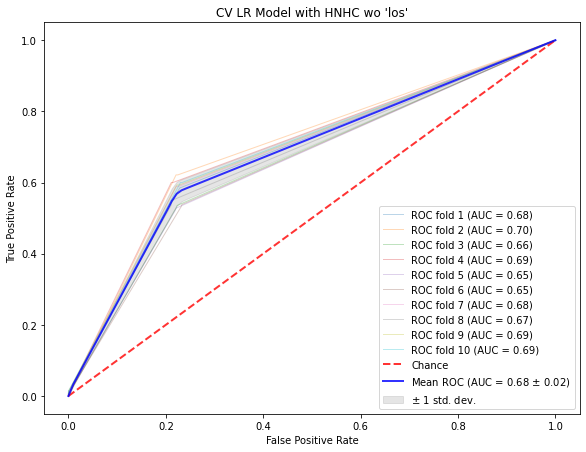

In [37]:
# Cross validated ROC/AUC chart, run classifier with cross-validation and plot ROC curves.
draw_cv_auc_roc(model_lr_hnhc_no_los, cv, cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los, num_features, "CV LR Model with HNHC wo 'los'")

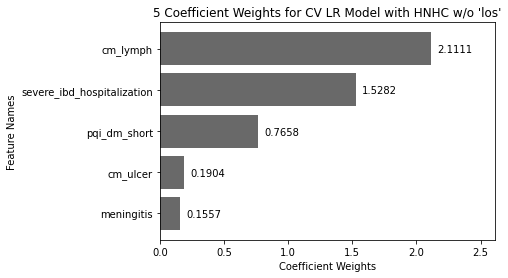

In [39]:
# Grab the coefficient weights using the Logistic Regression model.
for value in model_lr_hnhc_no_los.coef_:
    importance_lr_hnhc_no_los = sorted(zip(value, X_train_lr_hnhc_no_los))

# Graph coefficient weights for Logistic Regression.
value_labels_lr_hnhc_no_los = [x[0] for x in importance_lr_hnhc_no_los]
feature_names_lr_hnhc_no_los = [y[1] for y in importance_lr_hnhc_no_los]
plt.barh(feature_names_lr_hnhc_no_los, value_labels_lr_hnhc_no_los, color='dimgray')
for index, value in enumerate(value_labels_lr_hnhc_no_los):
    if value_labels_lr_hnhc_no_los[index] >= 0:
        plt.text(value/value_labels_lr_hnhc_no_los[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels_lr_hnhc_no_los[index] < 0:
        plt.text(-value/value_labels_lr_hnhc_no_los[index]+value+0.52, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((0, max(value_labels_lr_hnhc_no_los)+0.5))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Coefficient Weights for CV LR Model with HNHC w/o 'los'")
plt.savefig(f'{images_folder}\{num_features}_features\CV_LR_HNHC_no_los_Coefficient_Weights_{num_features}_validation', dpi=300)
plt.show()

## Decision Tree Classifier Validation - HNHC <a class="anchor" id="dtchnhc"></a> 

[Return to Table of Contents](#contents)

In [46]:
# Plug in the features found by the DTC RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from DTC RFE NRD 2013: ['age', 'los', 'orproc', 'cc_index', 'frailty_risk_score']
data_dtc_hnhc = ['hnhc_patients', 'age', 'los', 'cc_severity', 'hfrs_severity']

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc = validate_2013(data_dtc_hnhc, readm_df)

       hnhc_patients   age  los  cc_severity  hfrs_severity
0                0.0  88.0  1.0          0.0            0.0
1                0.0  49.0  3.0          1.0            0.0
2                0.0  63.0  2.0          1.0            0.0
3                0.0  54.0  3.0          0.0            0.0
5                0.0  83.0  5.0          2.0            2.0
...              ...   ...  ...          ...            ...
82384            0.0  63.0  7.0          2.0            1.0
82388            0.0  25.0  2.0          0.0            0.0
82393            0.0  41.0  0.0          1.0            0.0
82394            0.0  63.0  1.0          1.0            0.0
82400            0.0  54.0  3.0          0.0            0.0

[40177 rows x 5 columns]


In [47]:
# Initial model with Decision Tree Classifier
model_dtc_hnhc = DecisionTreeClassifier(random_state = 42, splitter = "best", max_depth = 5)
X_train_dtc_hnhc, X_test_dtc_hnhc, y_train_dtc_hnhc, y_test_dtc_hnhc = train_test_split(cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc, random_state=42)
model_dtc_hnhc.fit(X_train_dtc_hnhc, y_train_dtc_hnhc)
print(f'Training Score: {model_dtc_hnhc.score(X_train_dtc_hnhc, y_train_dtc_hnhc)}')
print(f'Testing Score: {model_dtc_hnhc.score(X_test_dtc_hnhc, y_test_dtc_hnhc)}')

Training Score: 0.9678414974113899
Testing Score: 0.9657541065206571


In [48]:
# K-Fold Validation using Decision Tree Classifier
scores_dtc_hnhc = cross_validate(model_dtc_hnhc, cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_dtc_hnhc = pd.DataFrame(scores_dtc_hnhc)
scores_df_dtc_hnhc

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.023957,0.009974,0.797952,0.791009,0.800000,0.925234,0.057143,0.078447,0.966650,0.967615
1,0.018923,0.007013,0.798739,0.795396,0.863636,0.852174,0.135714,0.077655,0.969139,0.967339
2,0.018949,0.006978,0.766980,0.798815,1.000000,1.000000,0.050000,0.066561,0.966899,0.967422
3,0.018980,0.006966,0.802243,0.787464,0.818182,0.895652,0.064286,0.081616,0.966899,0.967615
4,0.017983,0.007945,0.770642,0.797179,0.666667,0.866142,0.057143,0.087163,0.966152,0.967671
5,0.016948,0.007982,0.766030,0.794119,0.923077,0.913462,0.085106,0.075337,0.967646,0.967505
6,0.019946,0.007978,0.778542,0.792829,0.857143,0.913462,0.085106,0.075337,0.967397,0.967505
7,0.016981,0.007983,0.780080,0.797343,0.666667,0.952381,0.042857,0.079239,0.965895,0.967727
8,0.023937,0.007977,0.804540,0.793084,1.000000,0.916667,0.085714,0.078447,0.968135,0.967588
9,0.017920,0.007985,0.745381,0.792300,0.818182,0.918182,0.064286,0.080032,0.966891,0.967644


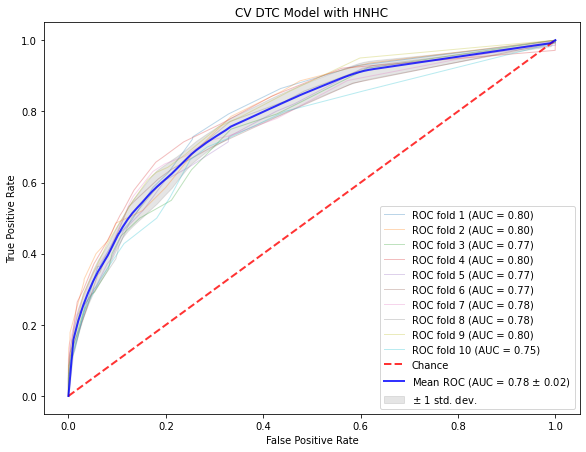

In [49]:
# Cross validated ROC/AUC chart, run classifier with cross-validation and plot ROC curves.
draw_cv_auc_roc(model_dtc_hnhc, cv, cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc, num_features, 'CV DTC Model with HNHC')

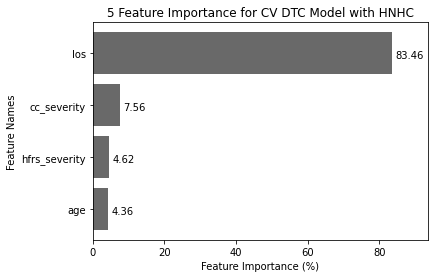

In [50]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance_dtc_hnhc = sorted(zip(model_dtc_hnhc.feature_importances_*100, X_train_dtc_hnhc))

# Graph feature importance for Decision Tree Classifier
value_labels_dtc_hnhc = [x[0] for x in importance_dtc_hnhc]
feature_names_dtc_hnhc = [y[1] for y in importance_dtc_hnhc]
plt.barh(feature_names_dtc_hnhc, value_labels_dtc_hnhc, color='dimgray')
for index, value in enumerate(value_labels_dtc_hnhc):
    plt.text(value/value_labels_dtc_hnhc[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_dtc_hnhc)+10))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV DTC Model with HNHC")
plt.savefig(f'{images_folder}\{num_features}_features_validation\CV_DTC_HNHC_Feature_Importance_{num_features}_validation', dpi=300)
plt.show()

## Decision Tree Classifier Validation - HNHC without 'los' <a class="anchor" id="dtchnhcwolos"></a> 

[Return to Table of Contents](#contents)

In [51]:
# Plug in the features found by the DTC RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from DTC RFE NRD 2013: ['age', 'orproc', 'severe_IBD_hospitalization', 'blood_transfusion', 'frailty_risk_score']
data_dtc_hnhc_no_los = ['hnhc_patients', 'age', 'severe_ibd_hospitalization', 'blood_transfusion', 'hfrs_severity']

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los = validate_2013(data_dtc_hnhc_no_los, readm_df)

       hnhc_patients   age  severe_ibd_hospitalization  blood_transfusion  \
0                0.0  88.0                         0.0                0.0   
1                0.0  49.0                         0.0                0.0   
2                0.0  63.0                         0.0                0.0   
3                0.0  54.0                         0.0                0.0   
5                0.0  83.0                         0.0                0.0   
...              ...   ...                         ...                ...   
82384            0.0  63.0                         1.0                0.0   
82388            0.0  25.0                         0.0                0.0   
82393            0.0  41.0                         0.0                0.0   
82394            0.0  63.0                         0.0                0.0   
82400            0.0  54.0                         0.0                1.0   

       hfrs_severity  
0                0.0  
1                0.0  
2     

In [52]:
# Initial model with Decision Tree Classifier
model_dtc_hnhc_no_los = DecisionTreeClassifier(random_state = 42, splitter = "best", max_depth = 5)
X_train_dtc_hnhc_no_los, X_test_dtc_hnhc_no_los, y_train_dtc_hnhc_no_los, y_test_dtc_hnhc_no_los = train_test_split(cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los, random_state=42)
model_dtc_hnhc_no_los.fit(X_train_dtc_hnhc_no_los, y_train_dtc_hnhc_no_los)
print(f'Training Score: {model_dtc_hnhc_no_los.score(X_train_dtc_hnhc_no_los, y_train_dtc_hnhc_no_los)}')
print(f'Testing Score: {model_dtc_hnhc_no_los.score(X_test_dtc_hnhc_no_los, y_test_dtc_hnhc_no_los)}')

Training Score: 0.9655183857692818
Testing Score: 0.9639621702339473


In [53]:
# K-Fold Validation using Decision Tree Classifier
scores_dtc_hnhc_no_los = cross_validate(model_dtc_hnhc_no_los, cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_dtc_hnhc_no_los = pd.DataFrame(scores_dtc_hnhc_no_los)
scores_df_dtc_hnhc_no_los

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.018943,0.008978,0.760190,0.764841,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
1,0.013963,0.006981,0.748480,0.767234,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
2,0.011968,0.009009,0.731654,0.769799,0.25,0.545455,0.007143,0.004754,0.964659,0.965126
3,0.011941,0.007010,0.779945,0.763825,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
4,0.012964,0.006981,0.744557,0.767882,0.00,0.000000,0.000000,0.000000,0.965157,0.965099
5,0.010999,0.007978,0.721118,0.769575,0.00,0.000000,0.000000,0.000000,0.964908,0.965126
6,0.012013,0.007979,0.757065,0.766057,0.00,0.000000,0.000000,0.000000,0.964908,0.965126
7,0.012965,0.006982,0.746078,0.767670,0.00,0.000000,0.000000,0.000000,0.965148,0.965100
8,0.010970,0.007979,0.748825,0.767643,0.00,0.000000,0.000000,0.000000,0.965148,0.965100
9,0.012965,0.007980,0.740374,0.768329,0.00,0.000000,0.000000,0.000000,0.965148,0.965100


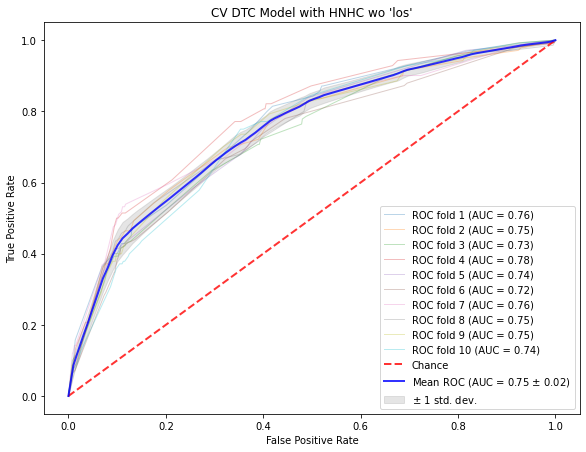

In [54]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_dtc_hnhc_no_los, cv, cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los, num_features, "CV DTC Model with HNHC wo 'los'")

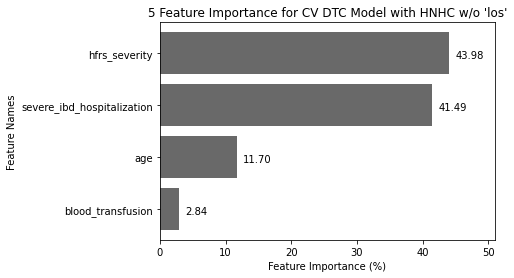

In [57]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance_dtc_hnhc_no_los = sorted(zip(model_dtc_hnhc_no_los.feature_importances_*100, X_train_dtc_hnhc_no_los))

# Graph feature importance for Decision Tree Classifier
value_labels_dtc_hnhc_no_los = [x[0] for x in importance_dtc_hnhc_no_los]
feature_names_dtc_hnhc_no_los = [y[1] for y in importance_dtc_hnhc_no_los]
plt.barh(feature_names_dtc_hnhc_no_los, value_labels_dtc_hnhc_no_los, color='dimgray')
for index, value in enumerate(value_labels_dtc_hnhc_no_los):
    plt.text(value/value_labels_dtc_hnhc_no_los[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_dtc_hnhc_no_los)+7))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV DTC Model with HNHC w/o 'los'")
plt.savefig(f'{images_folder}\{num_features}_features_validation\CV_DTC_HNHC_no_los_Feature_Importance_{num_features}_validation', dpi=300)
plt.show()

## XGBoost Classifier Validation - HNHC <a class="anchor" id="xgbchnhc"></a>

[Return to Table of Contents](#contents)

In [58]:
# Plug in the features found by the XGBClassifier RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from XGBClassifier RFE NRD 2013: ['los', 'orproc', 'cm_dmcx', 'cm_drug', 'chronic_pain']
data_xgbc_hnhc = ['hnhc_patients', 'los', 'cm_dmcx', 'cm_drug', 'chronic_pain']

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc = validate_2013(data_xgbc_hnhc, readm_df)

       hnhc_patients  los  cm_dmcx  cm_drug  chronic_pain
0                0.0  1.0      0.0      0.0           0.0
1                0.0  3.0      0.0      0.0           0.0
2                0.0  2.0      0.0      0.0           0.0
3                0.0  3.0      0.0      0.0           0.0
5                0.0  5.0      0.0      0.0           0.0
...              ...  ...      ...      ...           ...
82384            0.0  7.0      0.0      0.0           0.0
82388            0.0  2.0      0.0      0.0           0.0
82393            0.0  0.0      0.0      0.0           0.0
82394            0.0  1.0      0.0      0.0           0.0
82400            0.0  3.0      0.0      0.0           0.0

[40177 rows x 5 columns]


In [59]:
# Initial model with XGBClassifier
model_xgbc_hnhc = XGBClassifier(random_state = 42, verbosity = 0, max_depth = 5)
X_train_xgbc_hnhc, X_test_xgbc_hnhc, y_train_xgbc_hnhc, y_test_xgbc_hnhc = train_test_split(cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc, random_state=42)
model_xgbc_hnhc.fit(X_train_xgbc_hnhc, y_train_xgbc_hnhc)
print(f'Training Score: {model_xgbc_hnhc.score(X_train_xgbc_hnhc, y_train_xgbc_hnhc)}')
print(f'Testing Score: {model_xgbc_hnhc.score(X_test_xgbc_hnhc, y_test_xgbc_hnhc)}')

Training Score: 0.9680738085756007
Testing Score: 0.966351418616227


In [60]:
# K-Fold Validation using XGBClassifier
scores_xgbc_hnhc = cross_validate(model_xgbc_hnhc, cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_xgbc_hnhc = pd.DataFrame(scores_xgbc_hnhc)
scores_df_xgbc_hnhc

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.425833,0.017952,0.751239,0.761418,0.750000,0.896000,0.064286,0.088748,0.966650,0.967836
1,0.432842,0.020943,0.773322,0.759015,0.809524,0.864000,0.121429,0.085578,0.968392,0.967615
2,0.426858,0.019947,0.716156,0.764589,0.727273,0.891473,0.057143,0.091125,0.966401,0.967892
3,0.439823,0.016954,0.777400,0.758487,0.923077,0.867188,0.085714,0.087956,0.967894,0.967698
4,0.428852,0.018950,0.714207,0.764453,0.916667,0.880000,0.078571,0.087163,0.967646,0.967726
5,0.437829,0.016954,0.731529,0.763409,1.000000,0.896552,0.085106,0.082474,0.967894,0.967671
6,0.436831,0.015957,0.758259,0.760896,0.769231,0.902439,0.070922,0.088025,0.966650,0.967864
7,0.425861,0.016953,0.761799,0.760265,0.666667,0.864662,0.057143,0.091125,0.966144,0.967782
8,0.438825,0.016955,0.773371,0.758940,0.846154,0.859375,0.078571,0.087163,0.967389,0.967644
9,0.429850,0.018949,0.770256,0.759220,0.785714,0.880000,0.078571,0.087163,0.967140,0.967727


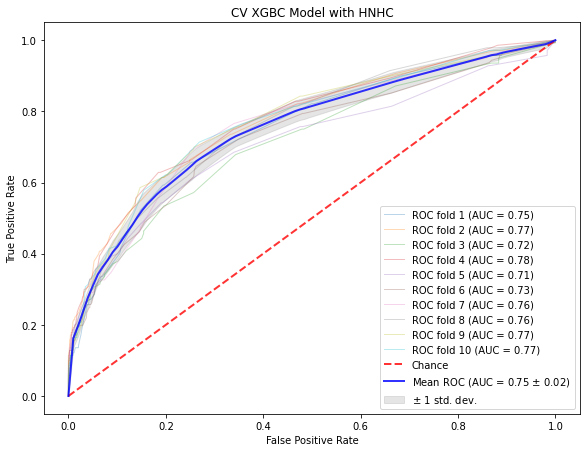

In [61]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_xgbc_hnhc, cv, cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc, num_features, 'CV XGBC Model with HNHC')

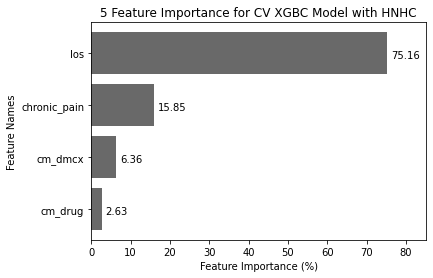

In [62]:
# Grab the feature importance using the cross validation XGBClassifier model
importance_xgbc_hnhc = sorted(zip(model_xgbc_hnhc.feature_importances_*100, X_train_xgbc_hnhc))

# Graph feature importance for XGBClassifier
value_labels_xgbc_hnhc = [x[0] for x in importance_xgbc_hnhc]
feature_names_xgbc_hnhc = [y[1] for y in importance_xgbc_hnhc] 
plt.barh(feature_names_xgbc_hnhc, value_labels_xgbc_hnhc, color='dimgray')
for index, value in enumerate(value_labels_xgbc_hnhc):
    plt.text(value/value_labels_xgbc_hnhc[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_xgbc_hnhc)+10))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV XGBC Model with HNHC")
plt.savefig(f'{images_folder}\{num_features}_features_validation\CV_XGBC_HNHC_Feature_Importance_{num_features}_validation', dpi=300)
plt.show()

## XGBoost Classifier Validation - HNHC without 'los' <a class="anchor" id="xgbchnhcwolos"></a>

[Return to Table of Contents](#contents)

In [63]:
# Plug in the features found by the XGBClassifier RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from XGBClassifier RFE NRD 2013: ['orproc', 'payer', 'severe_IBD_hospitalization', 'cm_wghtloss', 'blood_transfusion']
data_xgbc_hnhc_no_los = ['hnhc_patients', 'payer', 'severe_ibd_hospitalization', 'cm_wghtloss', 'blood_transfusion']

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los = validate_2013(data_xgbc_hnhc_no_los, readm_df)

       hnhc_patients  payer  severe_ibd_hospitalization  cm_wghtloss  \
0                0.0    0.0                         0.0          0.0   
1                0.0    0.0                         0.0          0.0   
2                0.0    0.0                         0.0          0.0   
3                0.0    1.0                         0.0          0.0   
5                0.0    0.0                         0.0          0.0   
...              ...    ...                         ...          ...   
82384            0.0    0.0                         1.0          0.0   
82388            0.0    0.0                         0.0          0.0   
82393            0.0    0.0                         0.0          0.0   
82394            0.0    0.0                         0.0          0.0   
82400            0.0    0.0                         0.0          0.0   

       blood_transfusion  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  


In [64]:
# Initial model with XGBClassifier
model_xgbc_hnhc_no_los = XGBClassifier(random_state=42, verbosity = 0, max_depth = 5)
X_train_xgbc_hnhc_no_los, X_test_xgbc_hnhc_no_los, y_train_xgbc_hnhc_no_los, y_test_xgbc_hnhc_no_los = train_test_split(cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los, random_state=42)
model_xgbc_hnhc_no_los.fit(X_train_xgbc_hnhc_no_los, y_train_xgbc_hnhc_no_los)
print(f'Training Score: {model_xgbc_hnhc_no_los.score(X_train_xgbc_hnhc_no_los, y_train_xgbc_hnhc_no_los)}')
print(f'Testing Score: {model_xgbc_hnhc_no_los.score(X_test_xgbc_hnhc_no_los, y_test_xgbc_hnhc_no_los)}')

Training Score: 0.9654520111509359
Testing Score: 0.9640617222498755


In [65]:
# K-Fold Validation using XGBClassifier
scores_xgbc_hnhc_no_los = cross_validate(model_xgbc_hnhc_no_los, cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_xgbc_hnhc_no_los = pd.DataFrame(scores_xgbc_hnhc_no_los)
scores_df_xgbc_hnhc_no_los

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.378985,0.015958,0.746362,0.732728,0.0,0.0,0.0,0.0,0.965157,0.965099
1,0.393947,0.015957,0.754523,0.732429,0.0,0.0,0.0,0.0,0.965157,0.965099
2,0.383974,0.018949,0.717862,0.736460,0.0,0.0,0.0,0.0,0.965157,0.965099
3,0.401925,0.018950,0.743401,0.733042,0.0,0.0,0.0,0.0,0.965157,0.965099
4,0.369013,0.016954,0.686660,0.739924,0.0,0.0,0.0,0.0,0.965157,0.965099
5,0.385967,0.014960,0.719798,0.735853,0.0,0.0,0.0,0.0,0.964908,0.965126
6,0.384970,0.017952,0.731716,0.734571,0.0,0.0,0.0,0.0,0.964908,0.965126
7,0.397935,0.015957,0.735374,0.733988,0.0,0.0,0.0,0.0,0.965148,0.965100
8,0.381978,0.015956,0.732298,0.734677,0.0,0.0,0.0,0.0,0.965148,0.965100
9,0.385967,0.018950,0.737772,0.734006,0.0,0.0,0.0,0.0,0.965148,0.965100


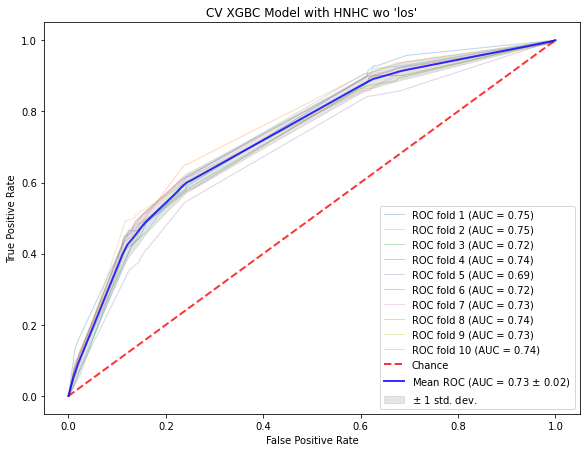

In [66]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_xgbc_hnhc_no_los, cv, cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los, num_features, "CV XGBC Model with HNHC wo 'los'")

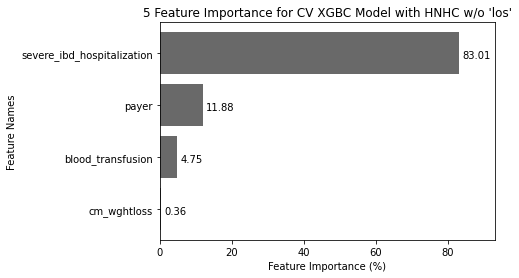

In [67]:
# Grab the feature importance using the cross validation XGBClassifier model
importance_xgbc_hnhc_no_los = sorted(zip(model_xgbc_hnhc_no_los.feature_importances_*100, X_train_xgbc_hnhc_no_los))

# Graph feature importance for XGBClassifier
value_labels_xgbc_hnhc_no_los = [x[0] for x in importance_xgbc_hnhc_no_los]
feature_names_xgbc_hnhc_no_los = [y[1] for y in importance_xgbc_hnhc_no_los]
plt.barh(feature_names_xgbc_hnhc_no_los, value_labels_xgbc_hnhc_no_los, color='dimgray')
for index, value in enumerate(value_labels_xgbc_hnhc_no_los):
    plt.text(value/value_labels_xgbc_hnhc_no_los[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_xgbc_hnhc_no_los)+10))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV XGBC Model with HNHC w/o 'los'")
plt.savefig(f'{images_folder}\{num_features}_features_validation\CV_XGBC_HNHC_no_los_Feature_Importance_{num_features}_validation', dpi=300)
plt.show()

## Target: READM_NINETY_DAYS <a class="anchor" id="ninety"></a> 

[Return to Table of Contents](#contents)

## Logistic Regression Validation - READM_NINETY_DAYS <a class="anchor" id="lrninety"></a> 

[Return to Table of Contents](#contents)

In [ ]:
# Plug in the features found by the LR RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from LR RFE NRD 2013: ['pq14_diabeteswocomp', 'pq16_dm_amputate', 'new_cardiacarrest_adm', 'new_fungal_adm', 'new_pcp_adm']
data_lr_ninety = ['has_90_day_readm', ]

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_lr_ninety, target_srs_lr_ninety = validate_2013(data_lr_ninety, readm_df)

In [ ]:
# Initial model with Logistic Regression.
model_lr_ninety = LogisticRegression(random_state = 42)
X_train_lr_ninety, X_test_lr_ninety, y_train_lr_ninety, y_test_lr_ninety = train_test_split(cleaned_data_wo_outcome_df_lr_ninety, target_srs_lr_ninety, random_state=42)
model_lr_ninety.fit(X_train_lr_ninety, y_train_lr_ninety)
print(f'Training Score: {model_lr_ninety.score(X_train_lr_ninety, y_train_lr_ninety)}')
print(f'Testing Score: {model_lr_ninety.score(X_test_lr_ninety, y_test_lr_ninety)}')

In [ ]:
# K-Fold Validation using Logistic Regression.
scores_lr_ninety = cross_validate(model_lr_ninety, cleaned_data_wo_outcome_df_lr_ninety, target_srs_lr_ninety, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_lr_ninety = pd.DataFrame(scores_lr_ninety)
scores_df_lr_ninety

In [ ]:
# Cross validated ROC/AUC chart, run classifier with cross-validation and plot ROC curves.
draw_cv_auc_roc(model_lr_ninety, cv, cleaned_data_wo_outcome_df_lr_ninety, target_srs_lr_ninety, num_features, 'CV LR Model with READM_NINETY_DAYS')

In [ ]:
# Grab the coefficient weights using the Logistic Regression model.
for value in model_lr_ninety.coef_:
    importance_lr_ninety = sorted(zip(value, X_train_lr_ninety))

# Graph coefficient weights for Logistic Regression.
value_labels_lr_ninety = [x[0] for x in importance_lr_ninety]
feature_names_lr_ninety = [y[1] for y in importance_lr_ninety]
plt.barh(feature_names_lr_ninety, value_labels_lr_ninety, color='dimgray')
for index, value in enumerate(value_labels_lr_ninety):
    if value_labels_lr_ninety[index] >= 0:
        plt.text(value/value_labels_lr_ninety[index]+value-0.97, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels_lr_ninety[index] < 0:
        plt.text(-value/value_labels_lr_ninety[index]+value+0.80, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels_lr_ninety)-0.25, max(value_labels_lr_ninety)+0.25))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Coefficient Weights for CV LR Model with READM_NINETY_DAYS")
plt.savefig(f'{images_folder}\{num_features}_features\CV_LR_READM_NINETY_DAYS_Coefficient_Weights_{num_features}_validation', dpi=300)
plt.show()

## Decision Tree Classifier Validation - READM_NINETY_DAYS <a class="anchor" id="dtcninety"></a> 

[Return to Table of Contents](#contents)

In [68]:
# Plug in the features found by the DTC RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from DTC RFE NRD 2013: ['age', 'los', 'orproc', 'payer', 'cc_index']
data_dtc_ninety = ['has_90_day_readm', 'age', 'los', 'payer', 'cc_severity']

cleaned_data_wo_outcome_df_dtc_ninety, target_srs_dtc_ninety = validate_2013(data_dtc_ninety, readm_df)

       has_90_day_readm   age  los  payer  cc_severity
0                   0.0  88.0  1.0    0.0          0.0
1                   0.0  49.0  3.0    0.0          1.0
2                   0.0  63.0  2.0    0.0          1.0
3                   0.0  54.0  3.0    1.0          0.0
5                   0.0  83.0  5.0    0.0          2.0
...                 ...   ...  ...    ...          ...
82384               1.0  63.0  7.0    0.0          2.0
82388               1.0  25.0  2.0    0.0          0.0
82393               0.0  41.0  0.0    0.0          1.0
82394               1.0  63.0  1.0    0.0          1.0
82400               1.0  54.0  3.0    0.0          0.0

[40177 rows x 5 columns]


In [69]:
# Initial model with Decision Tree Classifier
model_dtc_ninety = DecisionTreeClassifier(random_state = 42, splitter = "best", max_depth = 5)
X_train_dtc_ninety, X_test_dtc_ninety, y_train_dtc_ninety, y_test_dtc_ninety = train_test_split(cleaned_data_wo_outcome_df_dtc_ninety, target_srs_dtc_ninety, random_state=42)
model_dtc_ninety.fit(X_train_dtc_ninety, y_train_dtc_ninety)
print(f'Training Score: {model_dtc_ninety.score(X_train_dtc_ninety, y_train_dtc_ninety)}')
print(f'Testing Score: {model_dtc_ninety.score(X_test_dtc_ninety, y_test_dtc_ninety)}')

Training Score: 0.6457918491968672
Testing Score: 0.6399203583872574


In [70]:
# K-Fold Validation using Decision Tree Classifier.
scores_dtc_ninety = cross_validate(model_dtc_ninety, cleaned_data_wo_outcome_df_dtc_ninety, target_srs_dtc_ninety, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_dtc_ninety = pd.DataFrame(scores_dtc_ninety)
scores_df_dtc_ninety

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.021972,0.009974,0.631263,0.626478,0.552055,0.543768,0.269926,0.264032,0.647337,0.644266
1,0.017954,0.008008,0.594570,0.630272,0.491477,0.548329,0.231748,0.272369,0.625436,0.646312
2,0.016955,0.008977,0.621349,0.627454,0.531205,0.552560,0.245144,0.257853,0.639124,0.646699
3,0.018948,0.007981,0.620307,0.627639,0.560078,0.561837,0.193570,0.201206,0.643853,0.644929
4,0.017947,0.007977,0.611745,0.628320,0.497717,0.557931,0.219022,0.240881,0.627675,0.647059
5,0.018982,0.006984,0.628701,0.626418,0.557610,0.550000,0.262559,0.251377,0.648581,0.645455
6,0.016922,0.008018,0.629794,0.626674,0.568940,0.545298,0.262559,0.259416,0.652066,0.644487
7,0.017954,0.008971,0.614144,0.628319,0.540830,0.547873,0.270777,0.263640,0.643764,0.645575
8,0.019930,0.009974,0.631189,0.625749,0.556942,0.554009,0.239276,0.237067,0.646751,0.645631
9,0.018952,0.009980,0.627168,0.627132,0.529880,0.548587,0.267426,0.263044,0.639781,0.645769


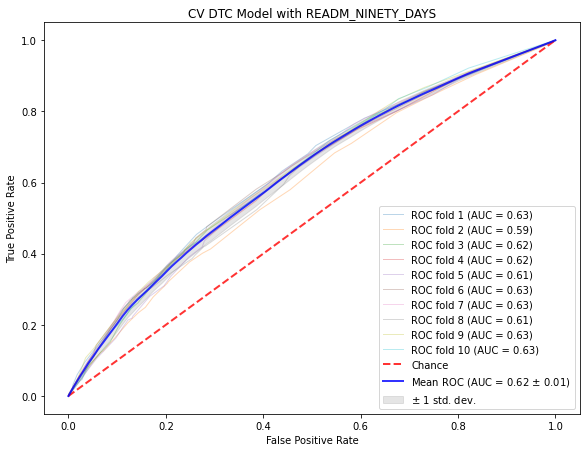

In [71]:
# Cross validated ROC/AUC chart, run classifier with cross-validation and plot ROC curves.
draw_cv_auc_roc(model_dtc_ninety, cv, cleaned_data_wo_outcome_df_dtc_ninety, target_srs_dtc_ninety, num_features, 'CV DTC Model with READM_NINETY_DAYS')

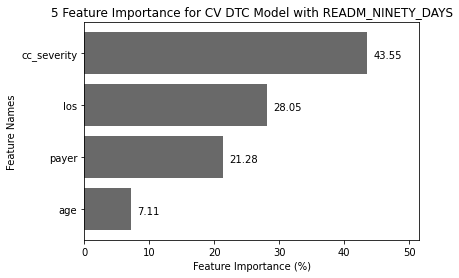

In [72]:
# Grab the feature importance using the cross validation Decision Tree Classifier model.
importance_dtc_ninety = sorted(zip(model_dtc_ninety.feature_importances_*100, X_train_dtc_ninety))

# Graph feature importance for Decision Tree Classifier.
value_labels_dtc_ninety = [x[0] for x in importance_dtc_ninety]
feature_names_dtc_ninety = [y[1] for y in importance_dtc_ninety]
plt.barh(feature_names_dtc_ninety, value_labels_dtc_ninety, color='dimgray')
for index, value in enumerate(value_labels_dtc_ninety):
    plt.text(value/value_labels_dtc_ninety[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_dtc_ninety)+8))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV DTC Model with READM_NINETY_DAYS")
plt.savefig(f'{images_folder}\{num_features}_features\CV_DTC_READM_NINETY_DAYS_Feature_Importance_{num_features}_validation', dpi=300)
plt.show()

## XGBoost Classifier Validation - READM_NINETY_DAYS <a class="anchor" id="xgbcninety"></a> 

[Return to Table of Contents](#contents)

In [74]:
# Plug in the features found by the XGBClassifier RFE process on the 2013 NRD file and repeat the same steps.
# These are the features from XGBClassifier RFE NRD 2013: ['elective', 'orproc', 'payer', 'ibd_procedures', 'cc_index']
data_xgbc_ninety = ['has_90_day_readm', 'elective', 'payer', 'ibd_procedures', 'cc_severity']

# Call the function to split and retrieve the target and feature set.
cleaned_data_wo_outcome_df_xgbc_ninety, target_srs_xgbc_ninety = validate_2013(data_xgbc_ninety, readm_df)

       has_90_day_readm  elective  payer  ibd_procedures  cc_severity
0                   0.0       1.0    0.0             0.0          0.0
1                   0.0       0.0    0.0             0.0          1.0
2                   0.0       0.0    0.0             0.0          1.0
3                   0.0       0.0    1.0             0.0          0.0
5                   0.0       0.0    0.0             0.0          2.0
...                 ...       ...    ...             ...          ...
82384               1.0       0.0    0.0             1.0          2.0
82388               1.0       0.0    0.0             0.0          0.0
82393               0.0       0.0    0.0             0.0          1.0
82394               1.0       0.0    0.0             0.0          1.0
82400               1.0       0.0    0.0             1.0          0.0

[40177 rows x 5 columns]


In [75]:
# Initial model with XGBClassifier
model_xgbc_ninety = XGBClassifier(random_state = 42, verbosity = 0, max_depth = 5)
X_train_xgbc_ninety, X_test_xgbc_ninety, y_train_xgbc_ninety, y_test_xgbc_ninety = train_test_split(cleaned_data_wo_outcome_df_xgbc_ninety, target_srs_xgbc_ninety, random_state=42)
model_xgbc_ninety.fit(X_train_xgbc_ninety, y_train_xgbc_ninety)
print(f'Training Score: {model_xgbc_ninety.score(X_train_xgbc_ninety, y_train_xgbc_ninety)}')
print(f'Testing Score: {model_xgbc_ninety.score(X_test_xgbc_ninety, y_test_xgbc_ninety)}')

Training Score: 0.639851320854905
Testing Score: 0.6342458934793429


In [76]:
# K-Fold Validation using XGBClassifier.
scores_xgbc_ninety = cross_validate(model_xgbc_ninety, cleaned_data_wo_outcome_df_xgbc_ninety, target_srs_xgbc_ninety, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_xgbc_ninety = pd.DataFrame(scores_xgbc_ninety)
scores_df_xgbc_ninety

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.293209,0.015957,0.619976,0.606698,0.551339,0.542857,0.165439,0.164061,0.639871,0.638098
1,0.382975,0.020944,0.574858,0.611683,0.495516,0.547816,0.148024,0.172696,0.627427,0.639675
2,0.275263,0.017952,0.611265,0.607697,0.547884,0.542297,0.164769,0.170835,0.639124,0.638375
3,0.276261,0.016954,0.610767,0.607620,0.538182,0.533204,0.198259,0.205002,0.638875,0.637960
4,0.411898,0.017951,0.602028,0.608603,0.493359,0.539328,0.174146,0.195995,0.626680,0.639094
5,0.390954,0.016954,0.610364,0.607668,0.537223,0.544150,0.178835,0.166518,0.637631,0.638513
6,0.409905,0.017951,0.617844,0.606929,0.551797,0.542443,0.174816,0.166964,0.640617,0.638181
7,0.314160,0.015958,0.599418,0.608942,0.532438,0.543930,0.159517,0.171418,0.635798,0.638744
8,0.281247,0.016955,0.615279,0.607199,0.580376,0.539114,0.186327,0.165687,0.647747,0.637389
9,0.301194,0.018950,0.596047,0.609255,0.527163,0.544694,0.175603,0.169632,0.635300,0.638800


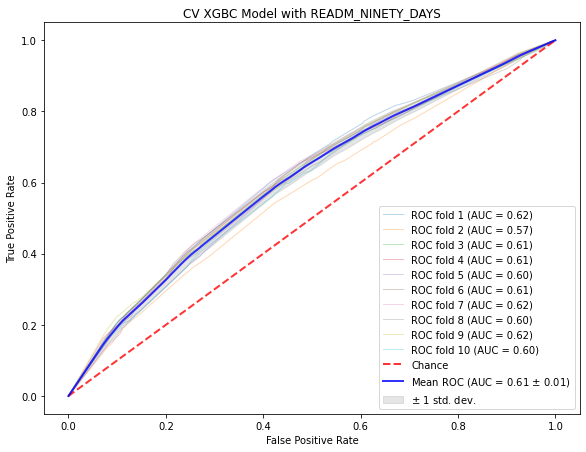

In [77]:
# Cross validated ROC/AUC chart, run classifier with cross-validation and plot ROC curves.
draw_cv_auc_roc(model_xgbc_ninety, cv, cleaned_data_wo_outcome_df_xgbc_ninety, target_srs_xgbc_ninety, num_features, 'CV XGBC Model with READM_NINETY_DAYS')

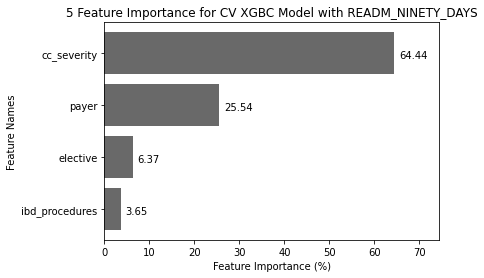

In [79]:
# Grab the feature importance using the cross validation XGBClassifier model.
importance_xgbc_ninety = sorted(zip(model_xgbc_ninety.feature_importances_*100, X_train_xgbc_ninety))

# Graph feature importance for XGBClassifier.
value_labels_xgbc_ninety = [x[0] for x in importance_xgbc_ninety]
feature_names_xgbc_ninety = [y[1] for y in importance_xgbc_ninety]
plt.barh(feature_names_xgbc_ninety, value_labels_xgbc_ninety, color='dimgray')
for index, value in enumerate(value_labels_xgbc_ninety):
    plt.text(value/value_labels_xgbc_ninety[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_xgbc_ninety)+10))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV XGBC Model with READM_NINETY_DAYS")
plt.savefig(f'{images_folder}\{num_features}_features\CV_XGBC_READM_NINETY_DAYS_Feature_Importance_{num_features}_validation', dpi=300)
plt.show()